<a href="https://colab.research.google.com/github/NkosikhonaD/experiements/blob/master/ProxyNCA_wits_lio_ac_iter_rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

In [ ]:
from pytorch_metric_learning import losses, miners, reducers, distances, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [ ]:

#------------------------------imports EmbeddingNet------------------#
import torch 
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam
import torchvision

import numpy as np
from numpy import mean
import torchvision.transforms as transforms
#------------------------------imports Sampler-----------------------#
from torch.utils.data.sampler import Sampler
from collections import defaultdict
import random
import torch.nn.functional as F

#------------------------------imports Dataset-----------------------#
from PIL import Image
import PIL.ImageOps

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import torchvision.datasets as dset

from torch.utils.data import Dataset

import os
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def set_parameter_requires_grad(model,feature_extrating):
  if feature_extrating:
    for param in model.parameters():
      param.requires_grad=False

In [ ]:
def initialize_model(model_name,num_classes,feature_extrating,use_pretrained= True):
  model_ft=None
  if model_name=="resnet18":
    model_ft= models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft,feature_extrating)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_classes)

  if model_name=="resnet34":
    model_ft= models.resnet34(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft,feature_extrating)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_classes)

  if model_name=="resnet50":
    model_ft= models.resnet50(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft,feature_extrating)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_classes)
  
  if model_name=="resnet101":
    model_ft= models.resnet101(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft,feature_extrating)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_classes)
    
  if model_name=="resnet152":
    model_ft= models.resnet152(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft,feature_extrating)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_classes)
  if model_name =="VGG19":
    model_ft= models.vgg19(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft,feature_extrating)
    num_ftrs= model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
  if model_name =="VGG11":
    model_ft= models.vgg11(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft,feature_extrating)
    num_ftrs= model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
  
  if model_name =="densenet121":
    model_ft= models.densenet121(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft,feature_extrating)
    num_ftrs= model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs,num_classes)
  if model_name =="densenet201":
    model_ft= models.densenet201(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft,feature_extrating)
    num_ftrs= model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs,num_classes)
  return model_ft
  
  

In [ ]:
class EmbeddingNet(nn.Module):
  def __init__(self,model_name,num_classes,feature_extrating,use_pretrained):
    super(EmbeddingNet,self).__init__()
    self.backbone = model_name
    if model_name is None:
      #initialize_model(model_name,num_classes = 128,feature_extract,use_pretrained= True)
      self.backbone = models.resnet18(num_classes=128)
    else:
        self.backbone =initialize_model(model_name,num_classes,feature_extrating,use_pretrained)
    #self.backbone = backbone
  def forward(self,x):
    x=self.backbone(x)
    x= nn.functional.normalize(x,dim=1)
    return x


In [ ]:
def show_plot_two(x_axis_array1,y_axis_array1,y_axis_array2,graph_1_lab="gr1",graph_2_lab="gr2",title="set title",x_label="epoch",y_label="loss"):
  
  if len(x_axis_array1)!= len(y_axis_array1):
    ly1 =min(len(x_axis_array1),len(y_axis_array1))
    ly2 =min(len(x_axis_array1),len(y_axis_array2))
    
    plt.plot(x_axis_array1[:ly1],y_axis_array1[:ly1],label=graph_1_lab)
    plt.plot(x_axis_array1[:ly2],y_axis_array2[:ly2],label=graph_2_lab)
  else:
    plt.plot(x_axis_array1,y_axis_array1,label=graph_1_lab)
    plt.plot(x_axis_array1,y_axis_array2,label=graph_2_lab)

  plt.xlabel(x_label)
  plt.ylabel(y_label)   
  plt.title(title)
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
def show_plot(x_axis_array,y_axis_array, title="set title",x_label="set_xlabes",y_label="set_ylabels"):
  plt.plot(x_axis_array,y_axis_array)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
class OnlineTripletDataset(Dataset):
  def __init__(self,imageFolderDataset,transform=None,should_invert=True):
    self.imageFolderDataset = imageFolderDataset
    self.should_invert= should_invert
    self.transform = transform
    self.targets = [name[1] for name in self.imageFolderDataset.imgs]
    self.targets = list(set(self.targets))
    #self.targets = [img[1] for img in self.imageFolderDataset.imgs]
  def __getitem__(self,index):
    img0_tuple = random.choice(self.imageFolderDataset.imgs)
    img0 = Image.open(img0_tuple[0])
    target = img0_tuple[1]

    if self.should_invert:
      img0=PIL.ImageOps.invert(img0)
    if self.transform is not None:
      img0=self.transform(img0)
    return img0, torch.from_numpy(np.array([int(target)],dtype=np.float32))
  def __len__(self):
    return (len(self.imageFolderDataset.imgs))


In [ ]:
accuracy_list = []
embeds = []
labels= []
train_loss = []
test_loss = []
epoch_iterator = []
test_iterator = []
dists = None
targets = None

In [ ]:
def train_epoch(model,optimizer,loss_optimizer,criterion,data_loader,device,epoch,print_freq):
  
  model.train()
  running_loss = 0;
  running_frac_pos_triplets= 0
  epoch_iterator.append(epoch)
  for i, data in enumerate(data_loader):
    optimizer.zero_grad()
    samples, targets = data[0].to(device),data[1].to(device)
    targets = torch.flatten(targets)
    embeddings = model(samples)
    #loss,frac_pos_triplets = criterion(embeddings,targets)
    loss= criterion(embeddings,targets)
    loss.backward()
    optimizer.step()
    loss_optimizer.step()
    running_loss +=loss.item()

    #running_frac_pos_triplets+=float(frac_pos_triplets)

    if i%print_freq ==print_freq-1:
      i+=1
      avg_loss = running_loss/print_freq
      train_loss.append(avg_loss)
      
      #avg_trip =100.0*running_frac_pos_triplets/print_freq
      #print('[{:d}, {:d}] | loss: {:.4f} | % avg hard triplets: {:.2f}%'.format(epoch, i, avg_loss, avg_trip))
      print('[{:d}, {:d}] | loss: {:.4f}'.format(epoch, i, avg_loss))
      running_loss = 0
      running_frac_pos_triplets = 0

In [ ]:
def imshow(img,text=None,should_save= False):
  npimg = img.cpu().numpy()
  plt.axis("off")
  if text:
    plt.text(75,8,text,style='italic',fontweight='bold',bbox={'facecolor':'white','alpha':0.8,'pad':10})
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()
  

In [ ]:
def save(model,epoch,save_dir,file_name):
  file_name = 'epoch_'+str(epoch)+'_'+file_name
  save_path =os.path.join(save_dir,file_name)
  torch.save(model.state_dict(),save_path)

In [ ]:

folder_dataset_train = dset.ImageFolder(root="/content/drive/My Drive/Lion_Data/train")
#folder_dataset_test = dset.ImageFolder(root="/content/drive/My Drive/ColabNotebooks/DataProcessed/Nyla_Data/val")

train_dataset = OnlineTripletDataset(imageFolderDataset=folder_dataset_train,transform=transforms.Compose([transforms.Resize(128),transforms.CenterCrop(124),transforms.ToTensor()]),should_invert=False)
#test_dataset= OnlineTripletDataset(imageFolderDataset=folder_dataset_test,transform=transforms.Compose([transforms.Resize(28),transforms.CenterCrop(124),transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),should_invert=False)
  
targets = train_dataset.targets

train_dataloader = DataLoader(train_dataset,num_workers =4,batch_size=6)
print("Total targets = "+str(len(targets)))

Total targets = 96


In [ ]:
folder_dataset_test = dset.ImageFolder(root="/content/drive/My Drive/Lion_Data/val")
#folder_dataset_test = dset.ImageFolder(root="/content/drive/My Drive/ColabNotebooks/DataProcessed/Lion_Data/val")

#train_dataset = OnlineTripletDataset(imageFolderDataset=folder_dataset_train,transform=transforms.Compose([transforms.Resize(28),transforms.CenterCrop(24),transforms.ToTensor()]),should_invert=False)
test_dataset= OnlineTripletDataset(imageFolderDataset=folder_dataset_test,transform=transforms.Compose([transforms.Resize(128),transforms.CenterCrop(124),transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),should_invert=False)
targets_test = test_dataset.targets
print("targets test ",str(len(targets_test)))
test_dataloader = DataLoader(test_dataset,num_workers=4,batch_size=6,shuffle=False) 
device = torch.device('cuda')

targets test  94


In [ ]:
backbone_name = ["resnet18","resnet34","resnet50","resnet101","resnet152","VGG19","VGG11","densenet121","densenet201"]
feature_extract =True
extract_or_fine_tune=["tune","extr"]
dataset_used="Lion_Data"
backbone = backbone_name[8]
saved_model=backbone+extract_or_fine_tune[feature_extract]+dataset_used+".pt"
dim= [64,128,512]
dim_embedd = dim[2]
print(saved_model)

densenet201extrLion_Data.pt


In [ ]:
def get_all_embeddings(dataset,model):
  tester = testers.BaseTester()
  return tester.get_all_embeddings(dataset,model)

In [ ]:
def test(test1_samples,test2_samples,model,accuracy_calculator):
  test1_embeddings,test1_labels = get_all_embeddings(test1_samples,model)
  test2_embeddings,test2_labels = get_all_embeddings(test2_samples,model)
  accuracies = accuracy_calculator.get_accuracy(test1_embeddings,test2_embeddings,np.squeeze(test1_labels),np.squeeze(test2_labels),False)
  print("Test accuracy (precision@1) = {}".format(accuracies["precision_at_1"]))
  print("Test accuracy (mean average precision@R) = {}".format(accuracies["mean_average_precision_at_r"]))

In [ ]:

def test_epoch(model,criterion,loss_optimizer,data_loader,device,epoch,print_freq):
  model.eval()
  model.to(device)
  running_loss = 0;
  running_frac_pos_triplets= 0
  model_string = "/content/drive/My Drive/Lion_Data/epoch_"+str(epoch)+"_"+saved_model
  model.load_state_dict(torch.load(model_string))
  test_iterator.append(epoch)
  for i, data in enumerate(data_loader):
    samples, targets = data[0].to(device),data[1].to(device)
    targets = torch.flatten(targets)
    embeddings = model(samples) 
    loss_optimizer.step()
    loss= criterion(embeddings,targets)
    running_loss +=loss.item()
    if i%print_freq ==print_freq-1:
      i+=1
      avg_loss = running_loss/print_freq
      test_loss.append(avg_loss)
      print('[{:d}, {:d}] | loss: {:.4f}'.format(epoch, i, avg_loss))
      running_loss = 0
      running_frac_pos_triplets = 0

	 backbone.classifier.weight
	 backbone.classifier.bias
Training... densenet201
[1, 60] | loss: 4.5577
Training... densenet201
[2, 60] | loss: 4.4946
Training... densenet201
[3, 60] | loss: 4.4480
Training... densenet201
[4, 60] | loss: 4.3801
Training... densenet201
[5, 60] | loss: 4.3223
Training... densenet201
[6, 60] | loss: 4.2429
Training... densenet201
[7, 60] | loss: 4.2088
Training... densenet201
[8, 60] | loss: 4.1589
Training... densenet201
[9, 60] | loss: 4.1299
Training... densenet201
[10, 60] | loss: 4.0822
Training... densenet201
[11, 60] | loss: 4.0225
Training... densenet201
[12, 60] | loss: 3.9864
Training... densenet201
[13, 60] | loss: 3.9666
Training... densenet201
[14, 60] | loss: 3.9588
Training... densenet201
[15, 60] | loss: 3.9241
Training... densenet201
[16, 60] | loss: 3.8856
Training... densenet201
[17, 60] | loss: 3.8725
Training... densenet201
[18, 60] | loss: 3.8394
Training... densenet201
[19, 60] | loss: 3.8172
Training... densenet201
[20, 60] | loss: 

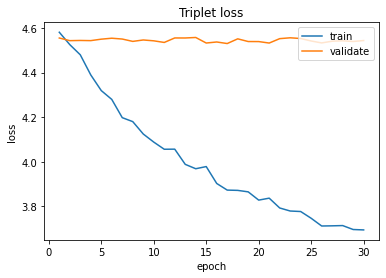

In [ ]:
test_loss = []
test_iterator = []

def main():
  feature_extract = True
  device = torch.device('cuda:0')
  model = EmbeddingNet(backbone,dim_embedd,feature_extract,True)
  model.to(device)
  params_to_update = model.parameters()
  if feature_extract:
    params_to_update= []
    for name, param in model.named_parameters():
      if param.requires_grad==True:
        params_to_update.append(param)
        print("\t",name)
  else:
    for name,param in model.named_parameters():
      if param.requires_grad==True:
        print("\t",name)
  
  print_freq = 60
  #criterion = TripletMarginLoss(margin =0.1) # hyper parameter margin can be changed
  criterion = losses.ProxyNCALoss(96,dim_embedd,softmax_scale=1)
  optimizer = Adam(params_to_update,lr=0.0001)
  loss_optimizer = Adam(criterion.parameters(),lr=0.0001)
  for epoch in range(1,31):
    print('Training...',backbone)
    train_epoch(model,optimizer,loss_optimizer,criterion,train_dataloader,device,epoch,print_freq)
    save(model,epoch,"/content/drive/My Drive/Lion_Data/",saved_model)
  feature_extract = False 
  
  model = EmbeddingNet(backbone,dim_embedd,feature_extract,True)

  #criterion = TripletMarginLoss(margin =0.1)
  criterion = losses.ProxyNCALoss(94,dim_embedd,softmax_scale=1)
  print_freq = 30
  for epoch in range(1,31):
    print('Testing ... ',backbone)
    test_epoch(model,criterion,loss_optimizer,test_dataloader,device,epoch,print_freq)    
  show_plot_two(test_iterator,train_loss,test_loss,"train","validate","Triplet loss")
if __name__ == '__main__':
  main()

In [ ]:
print("Evaluating model",backbone," extrator")
test_dataset1= OnlineTripletDataset(imageFolderDataset=folder_dataset_test,transform=transforms.Compose([transforms.Resize(128),transforms.CenterCrop(124),transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),should_invert=False)
test_dataset2= OnlineTripletDataset(imageFolderDataset=folder_dataset_test,transform=transforms.Compose([transforms.Resize(128),transforms.CenterCrop(124),transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),should_invert=False)

accuracy_calculator = AccuracyCalculator(include = ("precision_at_1","mean_average_precision_at_r",),k=1)
model = EmbeddingNet(backbone,dim_embedd,False,True)
model.to(device)
model_string = "/content/drive/My Drive/Lion_Data/epoch_"+str(30)+"_"+saved_model
model.load_state_dict(torch.load(model_string))
test(test_dataset1,test_dataset2,model,accuracy_calculator)

Evaluating model densenet201  extrator


100%|██████████| 6/6 [00:02<00:00,  2.38it/s]

Test accuracy (precision@1) = 0.727810650887574
Test accuracy (mean average precision@R) = 0.727810650887574


In [ ]:
print('Evaluating..',backbone)
#http://queirozf.com/entries/evaluation-metrics-for-ranking-problems-introduction-and-examples
#https://ils.unc.edu/courses/2013_spring/inls509_001/lectures/10-EvaluationMetrics.pdf
test_dataloader2 = DataLoader(test_dataset,num_workers=4,batch_size=1,shuffle=False)
model = EmbeddingNet(backbone,dim_embedd,False,True)
model.eval()
model.to(device)
accuracy_list = []
recall1_list = []
precision1_list = []

recall2_list = []
precision2_list = []

for i in range(1,30):
  accuracy = 0
  total = 0
  true_positive = 0
  true_negative = 0
  false_positive=0
  false_negative =0

  data_iter = iter(test_dataloader2)

  img0,target0 =next(data_iter)
  img0 = img0.to(device)
  target0 = target0.to(device)
  #print(target0.item())
  model_string = "/content/drive/My Drive/Lion_Data/epoch_"+str(30)+"_"+saved_model
  model.load_state_dict(torch.load(model_string))
  precision_c1 = 0.0
  recall_c1 = 0.0

  precision_c2 = 0.0
  recall_c2 = 0.0
  for i,data in enumerate(test_dataloader2):
    img1,target1 =data[0].to(device),data[1].to(device)
    embed0= model(img0)
    embed1= model(img1)
    contactenated = torch.cat((img0,img1),0)
    dist =  F.pairwise_distance(embed0,embed1)
    if target1.item() == target0.item():
      
      if dist<0.002:
        true_positive+=1
        total+=1
      else:
        false_positive+=1
        total+=1
    else:
        if dist>=0.002:
          true_negative+=1
          total+=1
        else:
          false_negative+=1
          total+=1
  acc = (true_positive+true_negative)/total
  accuracy_list.append(acc)
  if true_positive !=0: 
    recall_c1 = true_positive /(true_positive+false_negative) 
    recall1_list.append(recall_c1)
    precision_c1 =true_positive/(true_positive+false_positive)
    precision1_list.append(precision_c1)
  if true_negative!=0:
    precision_c2 = true_negative/(true_negative+false_positive)
    precision2_list.append(precision_c2)
    recall_c2 = true_negative/(true_negative+false_negative)
    recall2_list.append(recall_c2)

print('Accuracy: {0:.1f}, Recall: {1:.1f} Precision: {2:.1f}'.format(mean(accuracy_list),mean(recall1_list),mean(precision1_list)))
print('Accuracy: {0:.1f}, Recall: {1:.1f} Precision: {2:.1f}'.format(mean(accuracy_list),mean(recall2_list),mean(precision2_list)))

Evaluating.. resnet18
Accuracy: 1.0, Recall: 1.0 Precision: 0.6
Accuracy: 1.0, Recall: 1.0 Precision: 1.0


In [ ]:
def plot_dists(y_points1,y_points2,color1="blue",color2="orange"):
  list_size = len(y_points1)

  plt.scatter(y_points1,y_points1,c=color1,s=5,label="same label")
  #list_size = len(y_points2)
  #x_list = np.arange(0,list_size,1)
  new_list = y_points2[:list_size]
  plt.scatter(new_list,new_list,c=color2,s=5,label ="different label")
  plt.xlabel('distances range')
  plt.ylabel('distances')

  plt.legend(loc='upper left')
  plt.show()


In [ ]:
def plot_dists_all(y_points1,y_points2,color1="blue",color2="orange"):

  list_size = len(y_points1)
  x_list = np.linspace(0,30,num=list_size)
  plt.scatter(x_list,y_points1,c=color1,s=5,label="same label")
  list_size = len(y_points2)
  x_list = np.linspace(0,30,num=list_size)
  plt.scatter(x_list,y_points2,c=color2,s=5,label="different label")
  #plt.xlim(0.01,0.008)
  plt.xlabel('Batch')
  plt.ylabel('distances')

  plt.legend(loc='upper left')
  plt.show()

Plotting dists resnet18


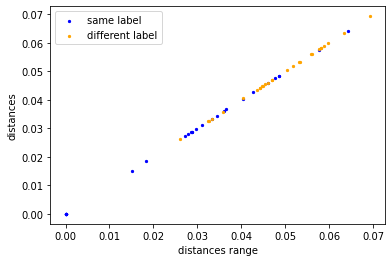

In [ ]:
print('Plotting dists',backbone)
#http://queirozf.com/entries/evaluation-metrics-for-ranking-problems-introduction-and-examples
#https://ils.unc.edu/courses/2013_spring/inls509_001/lectures/10-EvaluationMetrics.pdf
test_dataloader2 = DataLoader(test_dataset,num_workers=4,batch_size=1,shuffle=False)
model = EmbeddingNet(backbone,128,False,True)
model.eval()
model.to(device)
model_string = "/content/drive/My Drive/Lion_Data/epoch_"+str(30)+"_"+saved_model
#model_string = "/content/drive/My Drive/Lion_Data/epoch_30_extractres152lion.pt"
model.load_state_dict(torch.load(model_string))
accuracy_list = []
recall1_list = []
precision1_list = []

recall2_list = []
precision2_list = []

same_class_dists=[]
diff_class_dists=[]

same_class_dists_av=[]
diff_class_dists_av=[]
data_iter = iter(test_dataloader2)
for j in range(1,100):  
  img0,target0 =next(data_iter)
  img0 = img0.to(device)
  target0 = target0.to(device)
  embed0= model(img0)
  for i,data in enumerate(test_dataloader2):
    img1,target1 =data[0].to(device),data[1].to(device)
    embed1= model(img1)
    dist =  F.pairwise_distance(embed0,embed1)
    dist_a = round(dist.item(),4)
    if target1.item() == target0.item():
      same_class_dists.append(dist_a)
      if(j %5 == 0):
        same_class_dists_av.append(np.mean(same_class_dists))
        same_class_dists = []
    else:
      diff_class_dists.append(dist_a)
      if j%5 == 0 :
        diff_class_dists_av.append(np.mean(diff_class_dists))
        diff_class_dists = []
plot_dists(same_class_dists_av,diff_class_dists_av)
  

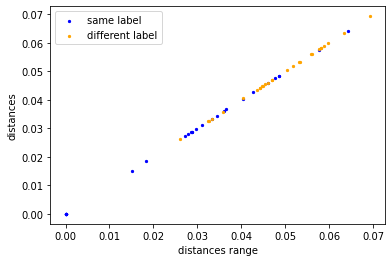

In [ ]:
plot_dists(same_class_dists_av,diff_class_dists_av)

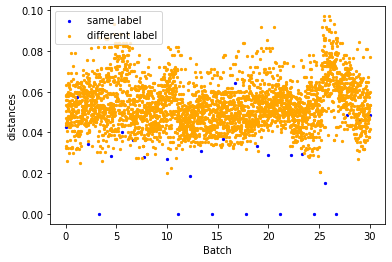

In [ ]:

plot_dists_all(same_class_dists_av,diff_class_dists_av)

In [ ]:
#plot_dists_all(same_class_dists_av,diff_class_dists_av)
print('Mean distance between images in same class {:.4f}'.format(np.mean(same_class_dists_av)))
print('Mean distance between images in different class {:.4f}'.format(np.mean(diff_class_dists_av)))


In [ ]:
print('Evaluation  mAP model',backbone)
#http://queirozf.com/entries/evaluation-metrics-for-ranking-problems-introduction-and-examples
#https://ils.unc.edu/courses/2013_spring/inls509_001/lectures/10-EvaluationMetrics.pdf
test_dataloader2 = DataLoader(test_dataset,num_workers=4,batch_size=1,shuffle=False)
model = EmbeddingNet(backbone,128,False,True)
model.eval()
model.to(device)
accuracy_list = []
recall1_list = []
precision1_list = []

relevant_items1 = 0
relevant_items2 = 0
recall2_list = []
precision2_list = []
#model_string = "/content/drive/My Drive/Lion_Data/epoch_"+str(30)+"_"+saved_model
model_string = "/content/drive/My Drive/Lion_Data/epoch_30_tuneres18lion.pt"
model.load_state_dict(torch.load(model_string))

mean_average_prec = []
data_iter = iter(test_dataloader2)
for i in range(1,100):
  dist_class = []
  img0,target0 =next(data_iter)
  img0 = img0.to(device)
  target0 = target0.to(device)
  for d,data in enumerate(test_dataloader2):
    img1,target1 =data[0].to(device),data[1].to(device)
    embed0= model(img0)
    embed1= model(img1)
    #contactenated = torch.cat((img0,img1),0)
    dist =  F.pairwise_distance(embed0,embed1)
    dist_r = round(dist.item(),4)
    if target1.item() == target0.item():
      relevant_items1=relevant_items1 + 1
      t = (dist_r,0)
      dist_class.append(t)
    else:
      relevant_items2=relevant_items2+1
      t = (dist_r,1)
      dist_class.append(t)
  dist_class.sort(key = lambda x: x[0])
  true_positive_class1 = 0
  false_positive_class1 = 0
  
  true_negative_class1 = 0
  false_negative_class1 = 0
  total = 0
  predicted_positive = 0
  p = 0
  for data in dist_class:
    distance,class_ind = data[0],data[1]
    if class_ind==0:
      total= total+1
      if distance<0.002:
        true_positive_class1=true_positive_class1+1
        predicted_positive=predicted_positive+1
        p = p+(true_positive_class1/total)
  
  ap =0
  if  predicted_positive>0:
    ap= p/predicted_positive
  precision1_list.append(ap)
  #if i%50 ==0:

  #print('AP@ : {0:.4f}'.format(ap))
print('mAP {:.4f}'.format(mean(precision1_list)))